#Data cleaning and formatting

In this notebook, we transform the 2020-quotesbank dataset in a graph. We use the graph to filter the speakers and the journals and to create new datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###you need restart kernel
!pip install pandas==1.0.5

     |████████████████████████████████| 10.1 MB 2.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.0.5 which is incompatible.


In [ ]:
import pathlib
import pandas as pd
from pathlib import Path
import bz2
from urllib.parse import urlparse
import networkx as nx
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt  

In [ ]:
quotebanks = Path('/content/drive/MyDrive/Quotebank')
save = Path('/content/drive/MyDrive/Quotebank')
quotebanks_2020 = quotebanks/'quotes-2020.json.bz2'
quotebanks_2020.exists()

True

In this part, we create an undirected weighted graph. To represent the name of the journal, we use the netloc of the url. When creating the graph we do several things.
- We drop the quotes which we don't know the speaker.
- We attribute an id to each nodes (the journal and the speaker) to do it, we increment a counter
- Each nodes has also 2 attributes : a label (speaker or journal name) and whether it is a journal or a speaker

In [ ]:
def get_domain(url):
    return  urlparse(url).netloc

In [ ]:
G = nx.Graph()
reader = pd.read_json(quotebanks_2020, lines=True, compression='bz2', chunksize=100000)

label_to_nodes_id = dict()
id_counter = 0

for i, chunck in enumerate(reader):
  edges = pd.DataFrame()
  edges['speaker'] = chunck['speaker']
  edges['journal'] = chunck['urls'].apply(lambda x: get_domain(x[0]))
  edges = edges[edges.speaker!='None']
 
  for _, row in edges.iterrows():
    speaker = row.speaker
    journal = row.journal


    if not speaker in label_to_nodes_id:
      G.add_node(id, label=speaker, kind='s')
      nodes_[speaker] = id
      id_counter += 1
    
    if not journal in label_to_nodes_id:
      G.add_node(id, label=journal, kind='j')
      nodes_[journal] = id
      id_counter += 1
    
    journal_id = label_to_nodes_id[speaker]
    speaker_id = label_to_nodes_id[journal]

    if not G.has_edge(journal_id, speaker_id):
      G.add_edge(journal_id, speaker_id, weight=1)
    else:
      G.edges[journal_id, speaker_id]['weight'] += 1
  
  print(f'{i}')
  if i==10:
    break

In [ ]:

#return an iterator on a (node, degree) list
def unweighted_degrees(graph) -> [(int, int)]:
  return G.degree()

def weighted_degrees(graph) -> [(int, int)]:
  return  G.degree(weight='weight')

#return a list of the nodes degrees
def list_degree(degrees_iterator) -> [int]:
  return [degree for id, degree in G.degree]

def connected_components(graph):
  return nx.connected_components(G)

def connected_components_sizes(graph):
  return np.array([len(c) for c in connected_components(graph)])

def graph_statisics(graph):
  print(f'number of nodes {len(graph.nodes)}')
  print(f'number of edges {len(graph.edges)}')
  print(f'number of connected components {len(connected_components_sizes(graph))}')

In [ ]:
####in place !!!!
def remove_nodes_with_degree_less(graph, than=2):
  ## we use unweighted degree as better representative of graph connectivity
  to_remove =  [ node for node, degree in unweighted_degrees(graph) if degree<=than]
  graph.remove_nodes_from(to_remove)
  return graph

def remove_components_with_size_less(graph, than=8):
  components_to_remove = [ component for component in connected_components(graph) if len(component)<=than]
  to_remove = [ node for component in components_to_remove for node in component ]
  graph.remove_nodes_from(to_remove)
  return graph

In [ ]:
#['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
#      'probas', 'urls', 'phase']


####considering the the nodes with a small degree is not very interseting to help us creating the graph
####however they can be very interesting when exploring a group as they may represent what differentiate a group
#### from other groups

We analyse the distributions of the nodes degrees, of the weighted nodes degrees and of the size of the connected components. 

We see it is a power law and we choose to exclude all nodes that have an unweighted degree less than 2. The rational behind it is that nodes with degree one don't cannot help us to cluster better the newspeppers or authors (even if it would be very useful to consider them when exploring a group as they may represent what differentiate a group
from other groups). We choose also to exclude nodes with degree 2 as it allows to significantally reduce the numbers of edges and empirically it does not seem to impact the analysis. Depending on the algorithm and the situation the thresold may vary.

We keep *80%* of the edges and *40%* of the nodes and the whole pipline is quite fast more or less 20 minutes and the graph quite small *3.5* MB. We can handle the amount of data.

In [ ]:
graph_statisics(G)

number of nodes 230354
number of edges 1044309
number of connected components 585


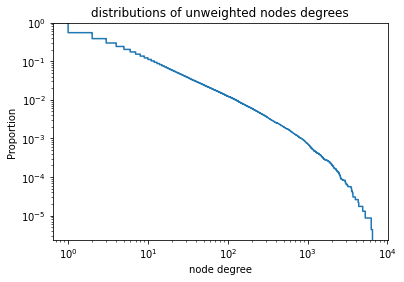

In [ ]:
sns.ecdfplot(data=list_degree(unweighted_degrees(G)), complementary=True, log_scale=(True, True), legend=False)

plt.title('distributions of unweighted nodes degrees')
plt.xlabel('node degree')
plt.yscale('log')
plt.xscale('log')

Text(0.5, 0, 'node degree')

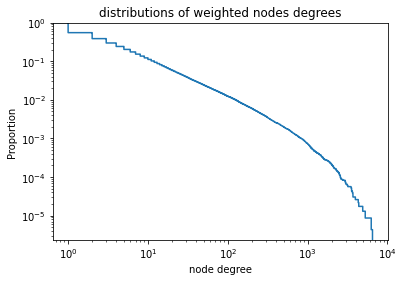

In [ ]:
sns.ecdfplot(data=list_degree(weighted_degrees(G)), complementary=True, log_scale=(True, True), legend=False)

plt.title('distributions of weighted nodes degrees')
plt.xlabel('node degree')

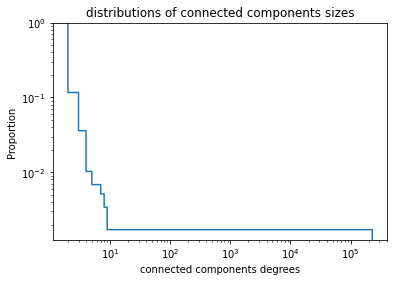

In [ ]:
sns.ecdfplot(data=connected_components_sizes(G), complementary=True, log_scale=(True, True), legend=False)

plt.title('distributions of connected components sizes')
plt.xlabel('connected components degrees')
plt.yscale('log')
plt.xscale('log')

In [ ]:
G = remove_nodes_with_degree_less(G, than=2)
graph_statisics(G)

number of nodes 88367
number of edges 865660
number of connected components 41


In [ ]:
G = remove_components_with_size_less(G, than=8)
graph_statisics(G)

number of nodes 88324
number of edges 865657
number of connected components 1


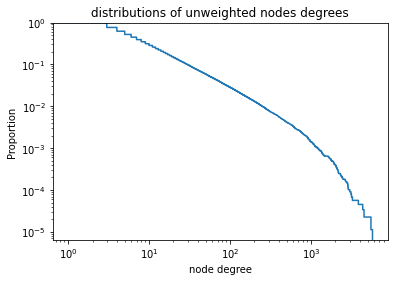

In [ ]:
sns.ecdfplot(data=list_degree(unweighted_degrees(G)), complementary=True, log_scale=(True, True), legend=False)

plt.title('distributions of unweighted nodes degrees')
plt.xlabel('node degree')
plt.yscale('log')
plt.xscale('log')

We visualize the graph and make a basic visual inspection to catch problems in the data. The main problem we identify, is that some entities are represented with several different names (ex *President trump*, *President donald trump*, *donald trump* ..), but with the amount of data we have it doesn't seem to be a big problem and there is not a way to solve it easily (without human intervention for each specific cases).

(cf in images : small_network_3.svg (un zoom to see full network), too heavy to fit in codelabs )

We save our dataset

In [ ]:
def save_as_edge_list(graph, path):
  edges = [{'source' : s, 'target' : t, 'type':'undirected','weight' : att['weight']} for s,t,att in graph.edges.data()]
  ### wrong format nx.readwrite.edgelist.write_edgelist(G,path)
  pd.DataFrame(edges).to_csv(path, index=False)

def save_nodes(graph, path):
  nodes = [ {'id' : id, 'label' : att['label'], 'kind' : att['kind']} for id, att in graph.nodes.data()]
  pd.DataFrame(nodes).to_csv(path, index=False)

def save_as_graph_nx(graph, path):
  nx.write_adjlist(graph, path)
def read_as_graph_nx(path):
  return nx.read_adjlist(path)

def save_as_pandas(graph, chuncks, path):
  all_speakers = [atts['label'] for _, atts in graph.nodes.data() if atts['kind']=='s']
  all_journals = [atts['label'] for _, atts in graph.nodes.data() if atts['kind']=='j']

  all_speakers = pd.DataFrame({'speaker' : all_speakers})
  all_journals = pd.DataFrame({'journal' : all_journals})

  header = True

  for i, chunck in enumerate(chuncks):
    chunck['journal'] = chunck['urls'].apply(lambda x: get_domain(x[0]))
    chunck.drop(columns=['quotation', 'phase', 'probas', 'numOccurrences', 'urls'], inplace=True) 
    chunck = chunck.merge(all_speakers, left_on='speaker', right_on='speaker')
    chunck = chunck.merge(all_journals, left_on='journal', right_on='journal')

    chunck.to_csv(path, header=header, mode='a')
    header = False
    
    print(i)
    if i==-1:
      break
 

